### PDF Display

In [1]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

<h1><center>Single Robot</center></h1>

## Specification in Omega
Following is the result of writing the specifications using the omega toolbox.

In [2]:
from omega.games import gr1
from omega.games import enumeration as enum
from omega.symbolic import temporal as trl
from omega.games.enumeration import action_to_steps
from omega.symbolic import enumeration as sym_enum
import networkx as nx

```
gridworld:

+------+------+------+
| x0y2 | x1y2 | x2y2 |
|site 2|      |      |
+------+------+------+
| x0y1 | x1y1 | x2y1 |
|      |      |      |
+------+------+------+
| x0y0 | x1y0 | x2y0 |
| home |      |site 1|
+------+------+------+

Dynamics:
x \in 0..2 /\ y \in 0..2
x' \in 0..2 /\ y' \in 0..2

((x' - x) < 2) /\ ((x' - x) > -2)
((y' - y) < 2) /\ ((y' - y) > -2)
```

In [3]:
aut = trl.Automaton()
aut.declare_variables(sysX=(0,2), sysY = (0,2), active=(1, 2), k = (0,1), goTo = (0,2), kR = (0,2))
aut.varlist['env']=['active']
aut.varlist['sys']=['sysX','sysY','k','kR','goTo']
aut.prime_varlists()

In [4]:
specs = '''
envInit ==
    /\ active = 1

envNext ==
    /\ (active \in 1..2 /\ active' \in 1..2)
    /\ (active' = active \/ active' != active) 

stat == (sysX' = sysX /\ sysY' = sysY)

dynamics == 
    /\ (sysX \in 0..2 /\ sysY \in 0..2)
    /\ (sysX' \in 0..2 /\ sysY' \in 0..2)

    /\ (((sysX' - sysX) < 2) /\ ((sysX' - sysX) > -2))
    /\ (((sysY' - sysY) < 2) /\ ((sysY' - sysY) > -2))

home == 
    /\ sysX = 0
    /\ sysY = 0

room1 == 
    /\ sysX = 2
    /\ sysY = 0

room2 == 
    /\ sysX = 0
    /\ sysY = 2

goTOR1 ==
    /\ ((sysX < 2) => (sysX' = sysX + 1))
    /\ ((sysY > 0) => (sysY' = sysY - 1))

goTOR2 ==
    /\ ((sysX > 0) => (sysX' = sysX - 1))
    /\ ((sysY < 2) => (sysY' = sysY + 1))

goTOHOME ==
    /\ ((sysX > 0) => (sysX' = sysX - 1))
    /\ ((sysY > 0) => (sysY' = sysY - 1))

sysInit ==
    /\ sysX = 0
    /\ sysY = 0
    /\ k = 1
    /\ goTo = 0
    /\ kR = 2

sysNext ==
    /\ dynamics
    /\ ((goTo = 0) => (goTOHOME))
    /\ ((goTo = 1) => (goTOR1))
    /\ ((goTo = 2) => (goTOR2))

    /\ ((home /\ (goTo = 1 \/ goTo = 2)) => (k' = k /\ kR' = kR /\ goTo' = goTo))
    /\ ((home /\ k = 1 /\ (kR = 1 \/ kR = 2) /\ goTo = 0) => (stat /\ k' = k /\ kR' = kR /\ goTo' = kR))

    /\ (((~home /\ ~room1 /\ ~room2)) => (k' = k /\ goTo' = goTo /\ kR' = kR))

    /\ ((room2 /\ active = 2 /\ goTo = 2) => (stat /\ k' = 1 /\ kR' = 2 /\ goTo' = 0))
    /\ ((room2 /\ goTo = 0) => (k' = 1 /\ kR' = 2 /\ goTo' = 0))
    /\ ((room2 /\ active != 2 /\ goTo = 2) => (stat /\ k' = 0 /\ kR' = 0 /\ goTo' = 1))
    /\ ((room2 /\ goTo = 1) => (k' = 0 /\ kR' = 0 /\ goTo' = 1))

    /\ ((room1 /\ active = 1 /\ goTo = 1) => (stat /\ k' = 1 /\ kR' = 1 /\ goTo' = 0))
    /\ ((room1 /\ goTo = 0) => (k' = 1 /\ kR' = 1 /\ goTo' = 0))
    /\ ((room1 /\ active != 1 /\ goTo = 1) => (stat /\ k' = 0 /\ kR' = 0 /\ goTo' = 2))
    /\ ((room1 /\ goTo = 2) => (k' = 0 /\ kR' = 0 /\ goTo' = 2))
'''

In [5]:
aut.define(specs)
aut.init.update(
    env='envInit',
    sys='sysInit')
aut.action.update(
    env='envNext',
    sys='sysNext')
aut.win['<>[]'] = aut.bdds_from('TRUE')
aut.win['[]<>'] = aut.bdds_from('sysX = 0 /\ sysY = 0')

In [6]:
aut.qinit = '\E \A'
aut.moore = True
aut.plus_one = True

z, yij, xijk = gr1.solve_streett_game(aut)
gr1.make_streett_transducer(z, yij, xijk, aut)
aut.varlist['sys'].append('_goal')
aut.prime_varlists()
# enumerate
g = enum.action_to_steps(aut, 'env', 'impl', qinit=aut.qinit)
h, _ = sym_enum._format_nx(g)
pd = nx.drawing.nx_pydot.to_pydot(h)
pd.write_pdf('outputs/gridworld_game_states_omega.pdf')
PDF('outputs/gridworld_game_states_omega.pdf',size=(900,900))

## Simulations

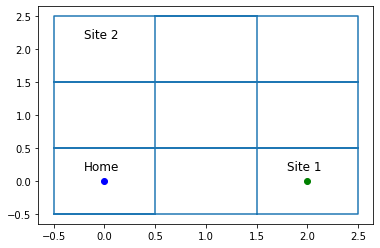

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

active = 1
activeX = 2
activeY = 0
robX = 0
robY = 0
current = 0
run = True  #set active == 0 to exit loop
while run:
    plt.plot([-0.5, 2.5, 2.5, -0.5, -0.5, 2.5, 2.5, -0.5, -0.5, 2.5, 2.5, -0.5, -0.5, 0.5, 0.5, 1.5, 1.5],
             [-0.5, -0.5, 0.5, 0.5, 1.5, 1.5, 2.5, 2.5, 1.5, 1.5, 0.5, 0.5, -0.5, -0.5, 2.5, 2.5, -0.5])
    plt.text(-.2, 0.16, "Home", fontsize=12)
    plt.text(1.8, 0.16, "Site 1", fontsize=12)
    plt.text(-.2, 2.16, "Site 2", fontsize=12)
    
    # environment
    plt.scatter([activeX],[activeY],c='green')
    # system
    plt.scatter([robX],[robY],c='blue')
    plt.show()
    # environment input
    active = int(input("Environment's next step is: "))
    plt.close()
    successors = list(g._succ[current].keys())
    
    if active == 1:
        activeX = 2
        activeY = 0
        for suc in successors:
            if g._node.get(suc)['active'] == 1:
                current = suc
    elif active == 2:
        activeX = 0
        activeY = 2
        for suc in successors:
            if g._node.get(suc)['active'] == 2:
                current = suc
    elif active == 0:   #set active == 0 to exit loop
        run = False
        print('Exiting Simulations')
        break
    robX = g._node.get(current)['sysX']
    robY = g._node.get(current)['sysY']
    print("Robot goes to: ({}, {})".format(robX,robY))
    time.sleep(1)
    clear_output(wait=True)